In [89]:
import datetime as dt
import pandas as pd
import numpy as np
df = pd.read_csv('sample_year.csv')
df["date_time"] = pd.to_datetime(df["date_time"])

In [90]:
# Profit Loss
pl_sum = df["profit_loss"].sum()
print(f"トータル損益\t\t: {pl_sum:,.0f}円")
# Ratio of WIn - Lose
win_sum = df.loc[df["profit_loss"]>=0, "profit_loss"].sum()
lose_sum = df.loc[df["profit_loss"] < 0, "profit_loss"].sum()
print(f"収益合計\t\t\t: {win_sum:,.0f}円")
print(f"損益合計\t\t\t: {lose_sum:,.0f}円")
# Swap PL
swap_total = df.loc[df["trade_category"] == "swap", "profit_loss"].sum()
print(f"スワップ損益合計\t\t: {swap_total:,.0f}円")
# Trade times
entry_cnt = (df["trade_category"] == "entry").sum()
exit_cnt = (df["trade_category"] == "exit").sum()
print(f"エントリー回数\t\t: {entry_cnt:,} 回")
# Count of Win - Lose
win_cnt = df.loc[df["profit_loss"]>0, "profit_loss"].count()
lose_cnt = df.loc[df["profit_loss"] < 0, "profit_loss"].count()
print(f"収益トレード\t\t: {win_cnt:,.0f}回")
print(f"損失トレード\t\t: {lose_cnt:,.0f}回")
print(f"勝率\t\t\t: {win_cnt / (win_cnt + lose_cnt) * 100:,.2f}％")
# Win pips
win_lot = df.loc[df["profit_loss"] > 0, "executed_amount"].sum()
win_pip = win_sum / win_lot
# Lose pips
lose_lot = df.loc[df["profit_loss"] < 0, "executed_amount"].sum()
lose_pip = lose_sum / lose_lot
print(f"収益トレード平均獲得PIPS\t: {win_pip:,.3f}")
print(f"損失トレード平均獲得PIPS\t: {lose_pip:,.3f}")
print(f"Risk Reward Ratio\t: {win_pip/-lose_pip:.2f}")
# Avg lot Win - Lose
win_lot_per_trade = win_lot / win_cnt
lose_lot_per_trade = lose_lot / lose_cnt
print(f"収益トレード平均建玉\t: {win_lot_per_trade:,.0f}通貨")
print(f"損失トレード平均建玉\t: {lose_lot_per_trade:,.0f}通貨")
# Entry bid ask
bid_entry= ((df["trade_category"] == "entry") & (df["bid_ask"] == "sell")).sum()
ask_entry= ((df["trade_category"] == "entry") & (df["bid_ask"] == "buy")).sum()
print(f"BID ASK エントリー回数\t: Bid => {bid_entry}, Ask => {ask_entry}")

トータル損益		: -820,890円
収益合計			: 18,133,988円
損益合計			: -18,954,878円
スワップ損益合計		: -142,514円
エントリー回数		: 11,003 回
収益トレード		: 8,455回
損失トレード		: 2,582回
勝率			: 76.61％
収益トレード平均獲得PIPS	: 0.027
損失トレード平均獲得PIPS	: -0.102
Risk Reward Ratio	: 0.27
収益トレード平均建玉	: 79,429通貨
損失トレード平均建玉	: 72,119通貨
BID ASK エントリー回数	: Bid => 5298, Ask => 5705


In [91]:
df.shape

(22166, 9)

In [92]:
# Remove trade_category of "swap" and "FXネオ手数料"
df = df[(df["trade_category"]=="entry") | (df["trade_category"]=="exit")]
# create entry and exit df
entry_df = df[df["trade_category"]=="entry"]
exit_df = df[df["trade_category"]=="exit"]

traded_currency_pair_list = entry_df["currency_pair"].drop_duplicates().to_list()

def match_ab_pairs(pair):
    """
    pair = [
      [{keyA1: valA1}, {keyA2: valA2}, ...],   # Aの配列
      [{keyB1: valB1}, {keyB2: valB2}, ...]   # Bの配列
    ]

    要件:
      1) Aの各要素(単一の値)は、Bの一つまたは複数の値の合計に等しい
      2) A, Bの全要素を使い切る
      3) 同じ合計条件なら、キーの値が近い(絶対値差)ものを優先
      4) 結果は [[A_key, [B_key(s)]]] という形式で返す
         例: [[1169, [1173]], [3084, [3088, 3089]]] など
    """

    # A_list, B_list を (key, value) のリストに変換
    a_list = [(list(d.keys())[0], list(d.values())[0]) for d in pair[0]]
    b_list = [(list(d.keys())[0], list(d.values())[0]) for d in pair[1]]

    # A, B の合計値が一致しない場合、解は存在しない
    sum_a = sum(val for _, val in a_list)
    sum_b = sum(val for _, val in b_list)
    if abs(sum_a - sum_b) > 1e-9:
        # 合計が違う → 解なし
        return None

    # キー昇順ソート: キーが近い順を優先したい時に役立つ
    a_sorted = sorted(a_list, key=lambda x: x[0])  # (keyA, valA)
    b_sorted = sorted(b_list, key=lambda x: x[0])  # (keyB, valB)

    #-----------------------------------------------
    # すべてのBの要素を partition して、各パーティションが A_val に一致するようにしたい
    # (Subset Sum の連続)
    # ここではバックトラックで全探索 (要素数が多い場合は爆発的に遅くなる)
    #-----------------------------------------------

    used = [False]*len(b_sorted)  # Bの要素を使用済みかどうか
    best_result = []
    best_score = float('inf')  # score = キー差の合計が小さいほど良い

    def backtrack(i, current_pairs, current_score):
        nonlocal best_result, best_score

        # ベースケース: Aのすべての要素を処理
        if i == len(a_sorted):
            # Bが全て使われているか確認
            if all(used):
                if current_score < best_score:
                    best_result = current_pairs[:]
                    best_score = current_score
            return

        a_key, a_val = a_sorted[i]

        # Bの部分集合を探す → 合計が a_val
        candidates = []

        def subset_sum_b(start, remaining, chosen, chosen_indices, chosen_key_diff):
            if abs(remaining) < 1e-9:
                # 完成
                # (B_keys, sum_of_key_diff, indices_list)
                candidates.append((chosen[:], chosen_key_diff, chosen_indices[:]))
                return
            if start >= len(b_sorted):
                return

            for idx in range(start, len(b_sorted)):
                if not used[idx]:
                    b_key, b_val = b_sorted[idx]
                    if b_val <= remaining + 1e-9:
                        new_diff = chosen_key_diff + abs(a_key - b_key)
                        chosen.append(b_key)
                        chosen_indices.append(idx)
                        subset_sum_b(idx+1, remaining - b_val, chosen, chosen_indices, new_diff)
                        chosen.pop()
                        chosen_indices.pop()

        subset_sum_b(0, a_val, [], [], 0)

        if not candidates:
            return  # 合計が a_val になる組合せがない→失敗

        # キー差が小さい順にソート
        candidates.sort(key=lambda x: x[1])

        # 候補を試す
        for bkeys, diff, indices in candidates:
            # indices の要素を used=True にして再帰
            for idx_b in indices:
                used[idx_b] = True

            backtrack(i+1, current_pairs+[[a_key, bkeys]], current_score+diff)

            # 巻き戻し
            for idx_b in indices:
                used[idx_b] = False

    backtrack(0, [], 0)
    return best_result

def gen_trade_set(entry_df,exit_df):
    set_list = []
    price_list = entry_df["executed_price"].drop_duplicates().to_list()
    # Making pair group
    pair_group_list = []
    for i in price_list:
        column_name = "executed_amount"
        condition_for_entry = entry_df["executed_price"] == i
        res_entry =  [{idx: val} for idx, val in entry_df.loc[condition_for_entry, column_name].items()]
        condition_for_exit = exit_df["entry_price"] == i
        res_exit =  [{idx: val} for idx, val in exit_df.loc[condition_for_exit, column_name].items()]
        pair_group_list.append([res_entry,res_exit])
    
    # Gen trade set
    for l in pair_group_list:
        entry_list = l[0]
        exit_list = l[1]
        entry_index_list = [list(d.keys())[0] for d in entry_list]
        exit_index_list = [list(d.keys())[0] for d in exit_list]
        if len(entry_list) == 1:
            entry_index = list(entry_list[0].keys())[0]
            if len(exit_list) == 1:
                set_list.append([entry_index,list(exit_list[0].keys())])
            else:
                set_list.append([entry_index,exit_index_list])
        elif (len(entry_index_list) == 2) and (len(exit_index_list) == 2):
            smaller_index = sorted(entry_index_list)[0]
            res_exit = exit_index_list[0] if abs(smaller_index - exit_index_list[0]) < abs(smaller_index - exit_index_list[1]) else exit_index_list[1]
            set_list.append([smaller_index,[res_exit]])
            set_list.append([sorted(entry_index_list)[1],[next(x for x in exit_index_list if x != res_exit)]])
        elif (len(entry_index_list) > 2) and (len(exit_index_list) > 2):
            res_matching = match_ab_pairs(l)
            set_list += res_matching
    
    return set_list
    
trade_set_list = []
currency_trade_set_list = []
for pair in traded_currency_pair_list:
    tmp_currency_set_list = []
    # entryDF
    tmp_entry_df = entry_df[entry_df["currency_pair"] == pair]
    # entryDFをbuy, sell に分割
    tmp_entry_buy_df = tmp_entry_df[tmp_entry_df["bid_ask"] == "buy"]
    tmp_entry_sell_df = tmp_entry_df[tmp_entry_df["bid_ask"] == "sell"]
    # exit DF
    tmp_exit_df = exit_df[exit_df["currency_pair"] == pair]
    # exitDFをbuy, sell に分割
    tmp_exit_buy_df = tmp_exit_df[tmp_exit_df["bid_ask"] == "buy"]
    tmp_exit_sell_df = tmp_exit_df[tmp_exit_df["bid_ask"] == "sell"]

    tmp_set1 = gen_trade_set(tmp_entry_buy_df,tmp_exit_sell_df)
    tmp_set2 = gen_trade_set(tmp_entry_sell_df,tmp_exit_buy_df)

    trade_set_list += tmp_set1
    trade_set_list += tmp_set2

    tmp_currency_set_list += tmp_set1
    tmp_currency_set_list += tmp_set2
    tmp_currency_set_list = sorted(tmp_currency_set_list, key=lambda x:x[0])
    dictionary = {pair:tmp_currency_set_list}
    currency_trade_set_list.append(dictionary)

trade_set_list = sorted(trade_set_list, key=lambda x:x[0])

In [93]:
columns = [
    "trade_set_list"
    ,"entry_date_time"
    ,"avg_exit_time"
    ,"currency_pair"
    ,"entry_bid_ask"
    ,"entry_amount"
    ,"entry_price"
    ,"avg_exit_price"
    ,"profit_loss"
    ,"hold_time_sec"
    ,"pips"
]

dtypes = {
    "trade_set_list" : object 
    ,"entry_date_time" : "datetime64[ns]"
    ,"avg_exit_time" : "datetime64[ns]"
    ,"currency_pair" : str
    ,"entry_bid_ask" : str
    ,"entry_amount" : float
    ,"entry_price" : float
    ,"avg_exit_price" : float
    ,"profit_loss" : float
    ,"hold_time_sec" : float
    ,"pips" : float
}
# 空のデータフレームを作成
trade_df = pd.DataFrame(columns=columns).astype(dtypes)

In [94]:
data_list = []
for l in trade_set_list:
    tmp_list = []
    
    # trade_set_list
    nested_tuple = tuple(tuple(x) if isinstance(x, list) else x for x in l)
    tmp_list.append(nested_tuple)
    
    # entry_date_time
    entry_time = df.loc[l[0],"date_time"]
    tmp_list.append(entry_time)
    
    # avg_exit_time ( calc )
    # 平均を取りたい date_time の行を選択（例えば index 0, 1, 2, 3）
    selected_dates = df.loc[l[1], "date_time"]
    # 選択した date_time の平均
    mean_date_time = selected_dates.mean()
    exit_time = mean_date_time
    tmp_list.append(exit_time)
    
    # currency_pair
    tmp_list.append(df.loc[l[0],"currency_pair"])
    
    # entry_bid_ask
    tmp_list.append(df.loc[l[0],"bid_ask"])
    
    # entry_amount
    entry_amount = df.loc[l[0],"executed_amount"]
    tmp_list.append(entry_amount)
    
    # entry_price
    entry_price = df.loc[l[0],"executed_price"]
    tmp_list.append(entry_price)
    
    # avg_exit_price ( calc )
    gokei = 0.0
    for i in l[1]:
        gokei += df.loc[i,"executed_price"]
    avg_exit_price = gokei/len(l[1])
    tmp_list.append(avg_exit_price)

    # sum_profit_loss
    sum_profit_loss = 0.0
    for i in l[1]:
        sum_profit_loss += df.loc[i,"profit_loss"]
    tmp_list.append(sum_profit_loss)

    # hold_time_sec
    # 差分を秒単位で取得し、小数点以下2桁で丸める
    diff_seconds = round((exit_time - entry_time).total_seconds(), 2)
    tmp_list.append(diff_seconds)
    
    # pips
    pips = sum_profit_loss / entry_amount
    tmp_list.append(pips)
        
    data_list.append(tmp_list)

In [95]:
# trade_dfにdata_listを代入
for i, row in enumerate(data_list):
    trade_df.loc[i] = pd.Series(row, index=trade_df.columns)
# すべての行を入れ終わったら改めて型を指定
trade_df = trade_df.astype(dtypes)

In [96]:
import matplotlib.pyplot as plt

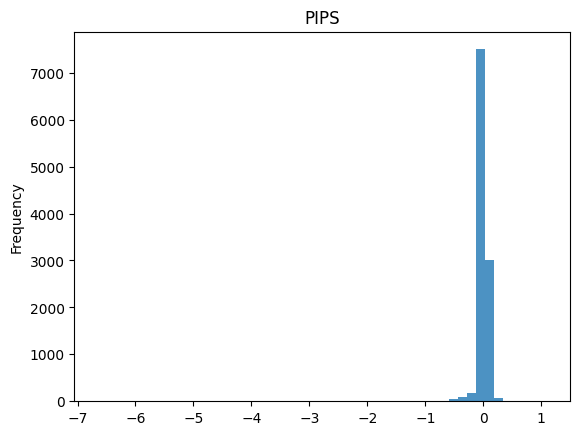

In [97]:
trade_df["pips"].plot.hist(title='PIPS', bins=50, alpha=0.8)
plt.show()

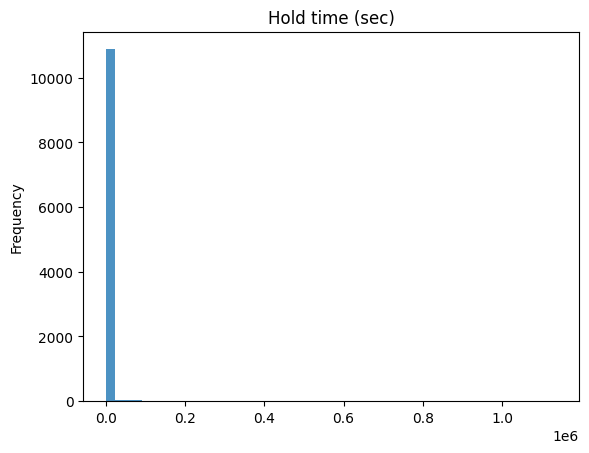

In [98]:
trade_df["hold_time_sec"].plot.hist(title='Hold time (sec)', bins=50, alpha=0.8)
plt.show()

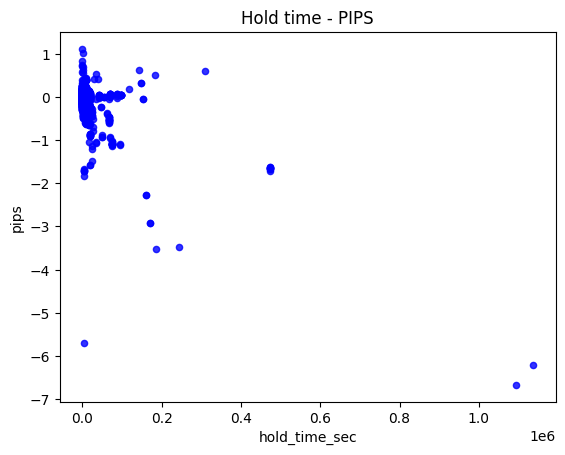

In [99]:
# 散布図を作成
trade_df[["hold_time_sec","pips"]].plot.scatter(title = "Hold time - PIPS", x="hold_time_sec", y="pips", alpha=0.8, color="blue")

# 表示
plt.show()